# Final Project - Machine Learning 
## Stroke Prediction 
### By: Andrea Leon, Jade McBride, and Clay Cleavinger
#### IE-4331
##### Date: May 10th, 2025

## Introduction


#### Goal:
A healthcare dataset is ussed to model and predict the likelihood of a person having a stroke based on several factors. The dataset includes information such as age, heart disease, average glucose level, and other demographic and life-style data. 
The goal is to build a supervised learning classifier that can predict if an individual is likely to suffer a stroke based on certain features.

#### Motivation:
Stroke is a major health issue that can cause health complications or death. Early detection of stroke risk is very important to be able to prevent and treat on time. A predictive model based on patient data can help identify high-risk patients early on, which could potentially improve outcomes and save lives. 


### How to Run
1. Open the **Final_Project_Code.ipynb** file in preferred environment
2. Make sure the dataset file **healthcare-dataset-stroke-data.csv** is in the **same folder**.
3. Run all cells from the top (Kernel → Restart & Run All) for a clean execution.

### Requirements
This project uses Python and the following libraries:
- pandas, numpy
- matplotlib, seaborn
- scikit-learn


In [7]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score
import numpy as np

In [8]:
# Load the dataset
df = pd.read_csv(r'/workspaces/MachineLearning/healthcare-dataset-stroke-data.csv')


## Exploratory Data Analysis


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB

Missing Values:
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000



Stroke Class Count:
stroke
0    4861
1     249
Name: count, dtype: int64

VISUALIZATION:

🔗 Pairwise Relationships:


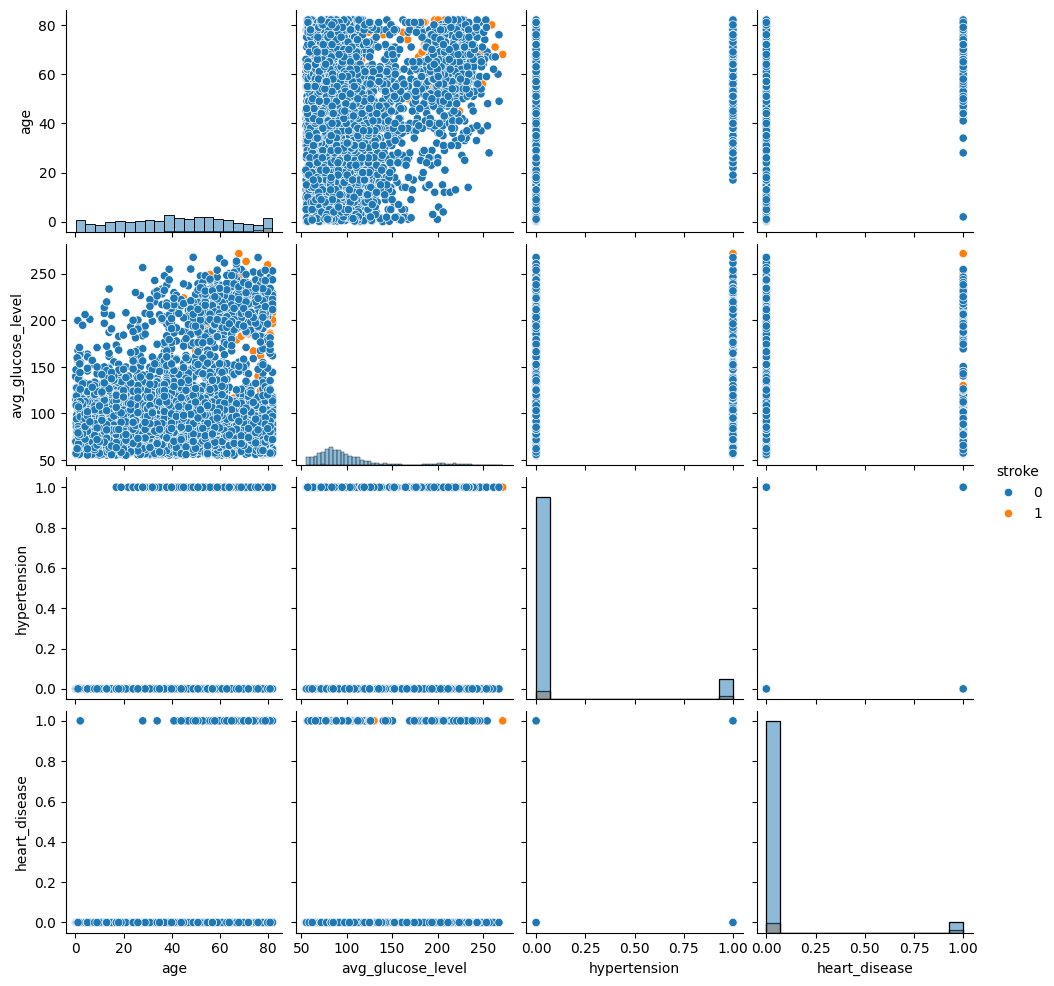


Correlation Matrix:


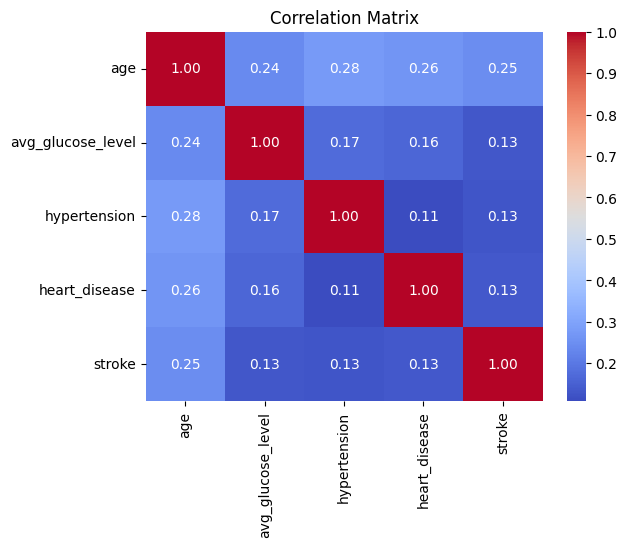

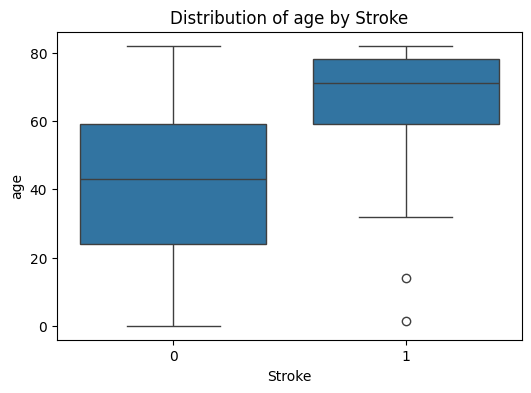

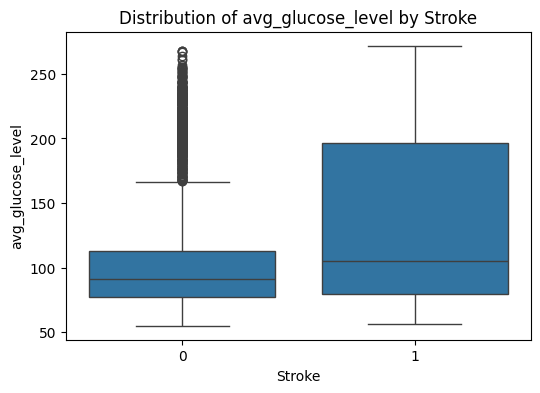

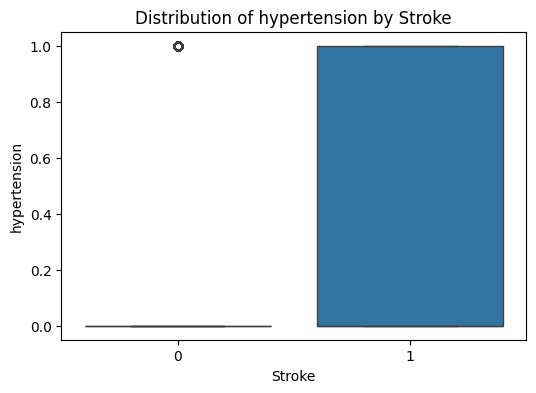

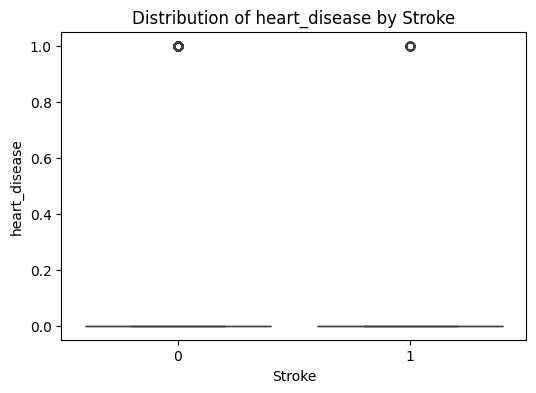

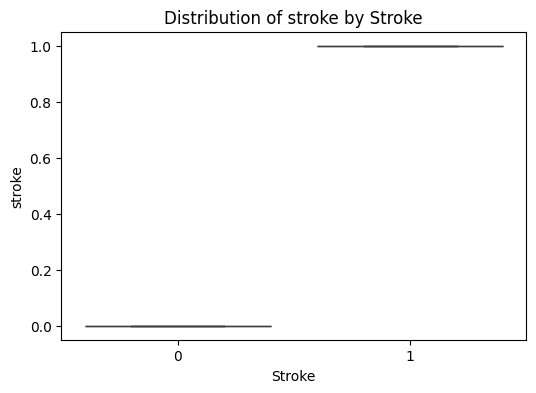


Feature Distribution:


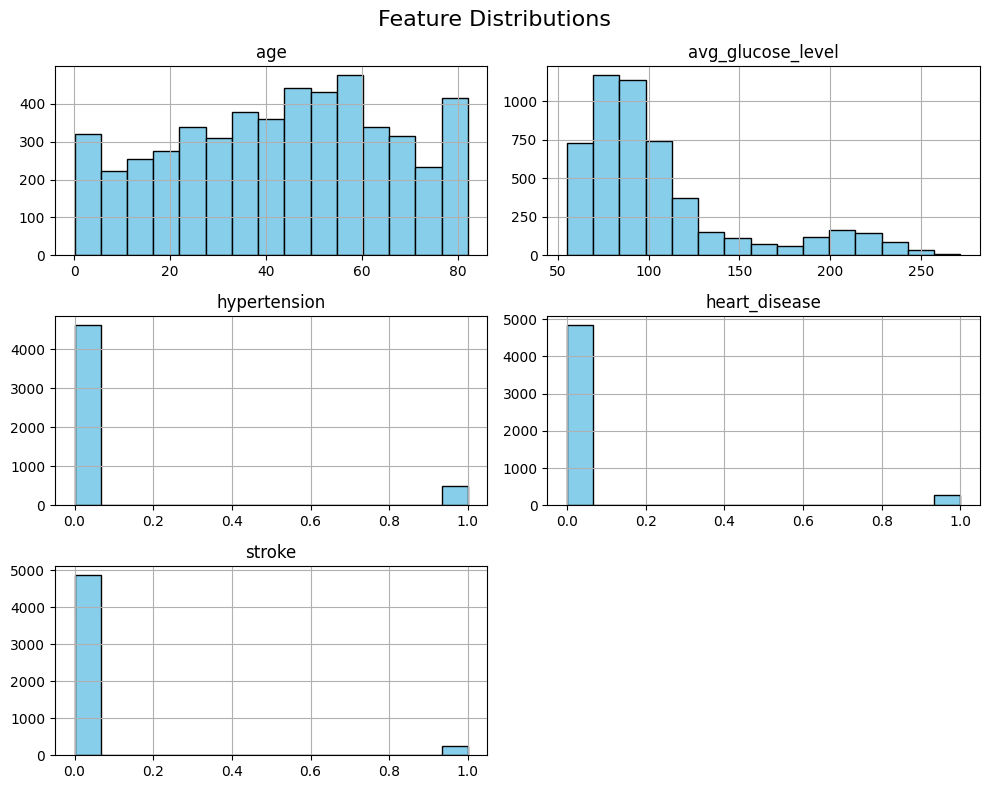

In [9]:
# Basic information about the dataset
print("\nDataset Info:")
df.info()

# Show missing values
missing_values = df.isnull().sum()
print("\nMissing Values:")
print(df.isnull().sum())

# Basic statistical summary
print("\nStatistical Summary:")
display(df.describe())

# Count the number of samples (stroke vs. no stroke)
print("\nStroke Class Count:")
print(df['stroke'].value_counts())

# VISUALIZATION
print("\nVISUALIZATION:")

# Pairplot to visualize relationships – important numerical features
print("\n🔗 Pairwise Relationships:")
selected_features = ['age', 'avg_glucose_level', 'hypertension', 'heart_disease', 'stroke']
sns.pairplot(df[selected_features].dropna(), hue='stroke', diag_kind='hist')
plt.show()

# Correlation matrix and heatmap
print("\nCorrelation Matrix:")
correlation_matrix = df[selected_features].dropna().corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Boxplots for feature distribution by stroke class
features = ['age', 'avg_glucose_level', 'hypertension', 'heart_disease', 'stroke']
for feature in features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='stroke', y=feature, data=df)
    plt.title(f'Distribution of {feature} by Stroke')
    plt.xlabel('Stroke')
    plt.ylabel(feature)
    plt.show()
    

# Histograms for each feature
print("\nFeature Distribution:")
df[features].hist(bins=15, figsize=(10, 8), color='skyblue', edgecolor='black')
plt.suptitle('Feature Distributions', fontsize=16)
plt.tight_layout()
plt.show()

#### Key Observations:
- There are **201** missing values in the **bmi** column.
- The **stroke** class is imbalanced with far more 0s (4,861) than 1s (249).
- Correlation between numeric features is weak, indicating independence.
- Older age and higher glucose levels may correlate with stroke.

## Data Preprocessing:
- Since the data was incredibly unbalanced, start by undersampling the majority class
- Then account for nonnumerical data and split into training and testing sets
- BMI is specially handled by creating a missing column to indicate any patient with 

In [10]:
#Since Data is harshly imbalanced we choose to undersample the majority class
majority_class = df[df['stroke'] == 0]  #There are more class 0 so it is the majority class
minority_class = df[df['stroke'] == 1]  #Class 1 is the minority class

#Randomly sample the majority class to match the minority class size
majority_class_undersampled = majority_class.sample(len(minority_class), random_state=42)

#Combine the undersampled majority class with the minority class
balanced_data = pd.concat([majority_class_undersampled, minority_class])

#Shuffle the datbase
balanced_data = shuffle(balanced_data, random_state=42)

#Split features and target
X = balanced_data.drop(columns=['stroke', 'id', 'ever_married', 'work_type', 'Residence_type', 'gender'])
Y = balanced_data['stroke']

#Handle Different Variable Types
categorical = X.select_dtypes(include=["object", "category"]).columns.tolist()
numerical = X.select_dtypes(include=["number"]).columns.tolist()

#Incorporate BMI missing to capture any potential relationship
X['bmi_missing'] = X['bmi'].isnull().astype(int)  # Add missing indicator column
X['bmi'] = X['bmi'].fillna(-1)                    # Impute with neutral value
numerical.append('bmi_missing')                   # Add to numerical list

#Handle non-numerical columns by creating new features based on them
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
X_cat_encoded = encoder.fit_transform(X[categorical])
cat_col_names = encoder.get_feature_names_out(categorical)
X_cat_df = pd.DataFrame(X_cat_encoded, columns=cat_col_names, index=X.index)

#Reincorporate both variable types
X_final = pd.concat([X[numerical], X_cat_df], axis=1)

# Split into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X_final, Y, test_size=0.2, random_state=42)

### Initialize Random Forest:
- Random Forest with n_estimators of 100 and a max depth per tree of 10
- These hyperparameters were found by manual search and provide high results with reasonable processing power requirements
- Graph is the second tree from the Random Forest

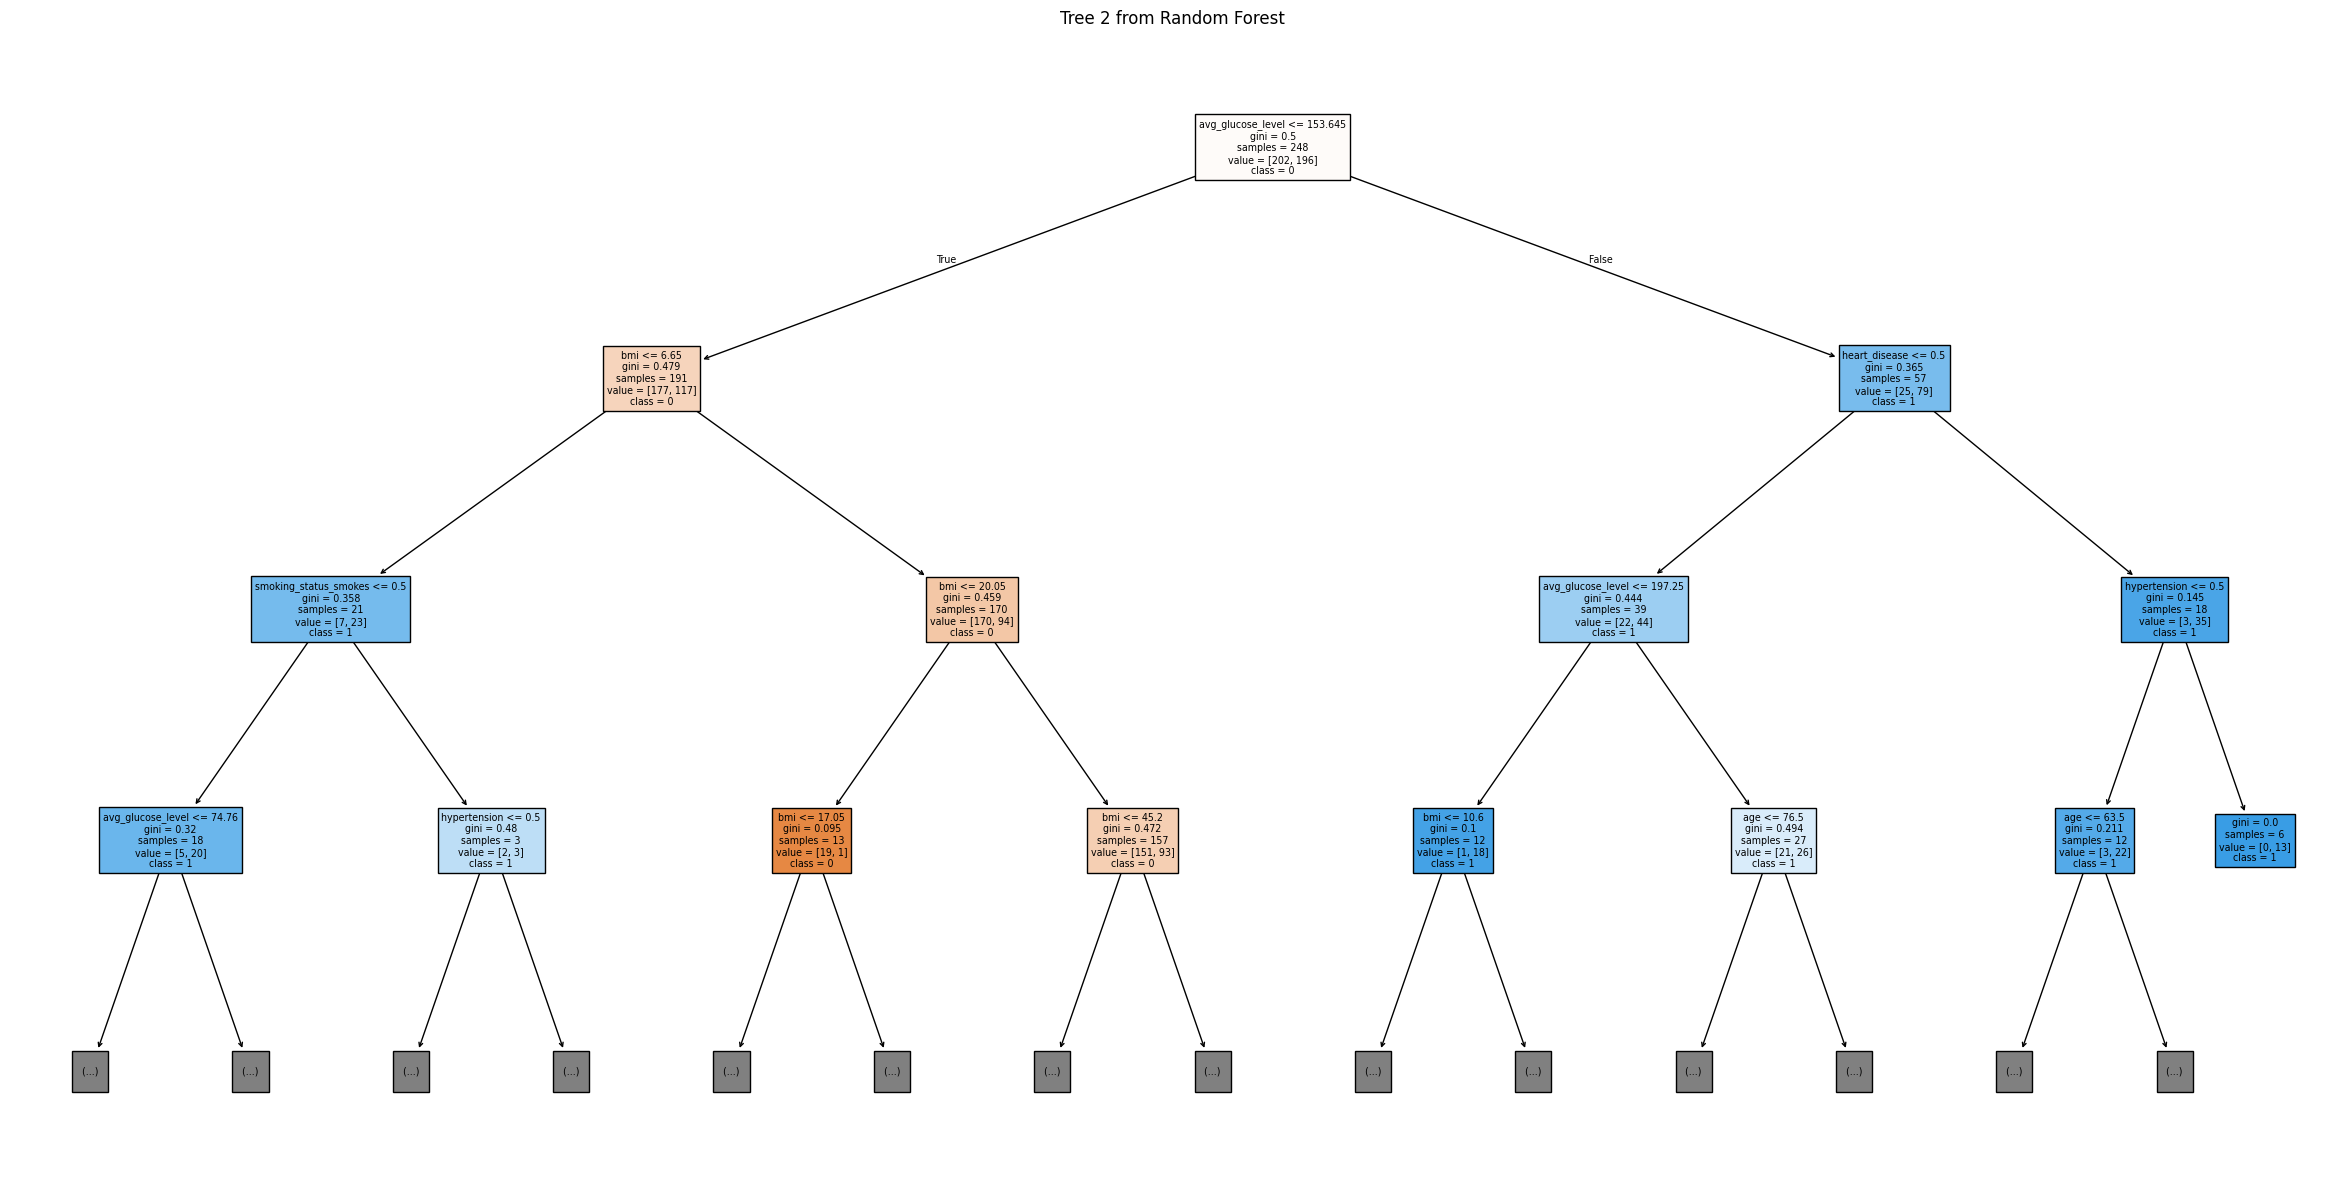

In [14]:
#Initialize Random Forest Algorithm
Tree = RandomForestClassifier(random_state=42, n_estimators=100, max_depth= 10) #Max depth of 10 gives best results and 100 n_estimators is just as effective as higher numbers
Tree.fit(X_train, y_train)

#Extract a tree
estimator = Tree.estimators_[1]

#Plot the figure with the training data's columns
plt.figure(figsize=(30, 15))
plot_tree(estimator,
          filled=True,
          feature_names=X_train.columns,  
          class_names=[str(cls) for cls in Tree.classes_], max_depth=3)
plt.title("Tree 2 from Random Forest")
plt.show()

### Calculate All Metrics

🔹 Classification Accuracy: 0.8100

Precision: 0.740
Recall:    0.860
F1 Score:  0.796
AUC ROC Score: 0.816


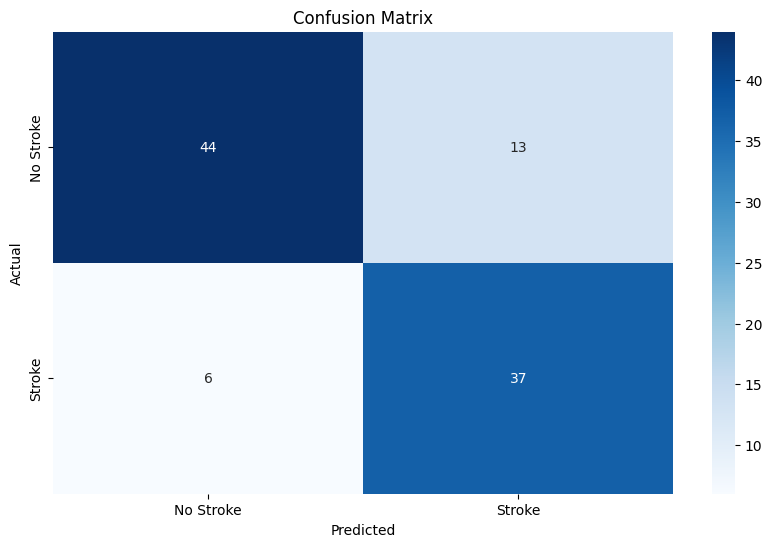

Feature Importances:
age: 0.4592
avg_glucose_level: 0.2113
bmi: 0.1795
hypertension: 0.0376
heart_disease: 0.0224
bmi_missing: 0.0223
smoking_status_smokes: 0.0193
smoking_status_formerly smoked: 0.0173
smoking_status_never smoked: 0.0159
smoking_status_Unknown: 0.0150


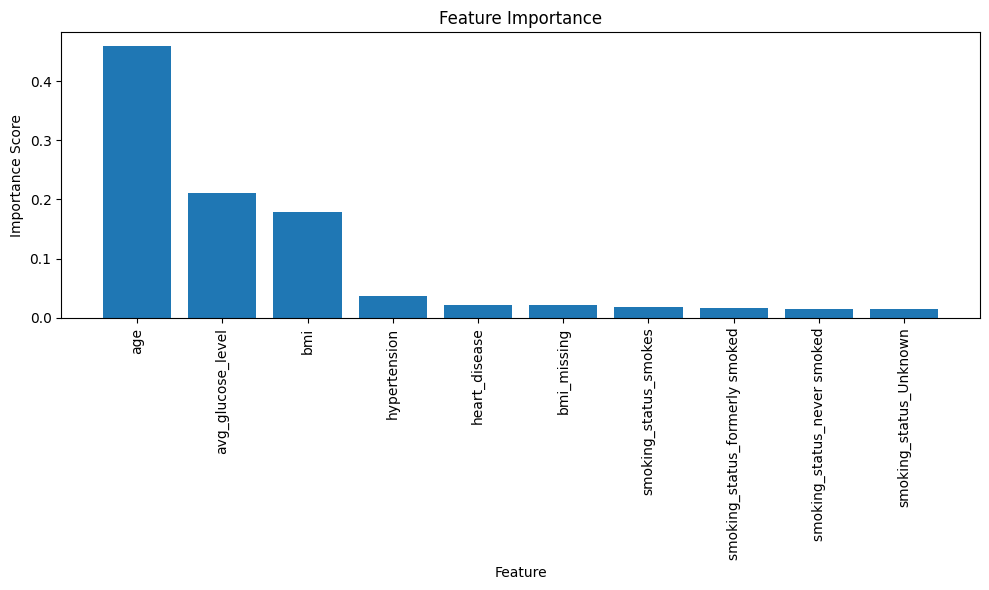

In [ ]:
#Make predictions
y_pred = Tree.predict(X_test)

#Print accuracy and report
accuracy = accuracy_score(y_test,y_pred)
print(f"🔹 Classification Accuracy: {accuracy:.4f}\n")
# print("🔹 Classification Report:\n", classification_report(y_test, y_pred))

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)

#Print Metrics
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")
print(f"AUC ROC Score: {roc:.3f}")

# Confusion Matrix
plt.figure(figsize=(10, 6))
labels = ["No Stroke", "Stroke"]  # or just ["0", "1"] if you prefer

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, 
            cmap="Blues", 
            fmt="d", 
            xticklabels=labels, 
            yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#Extract Feature Importances
importances = Tree.feature_importances_

feature_names = np.array(X_train.columns)  # Get feature names
sorted_indices = np.argsort(importances)[::-1] # Sort feature importances in descending order

#Print Importances
print("Feature Importances:")
for idx in sorted_indices:
    print(f"{feature_names[idx]}: {importances[idx]:.4f}")

#Graph Importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(len(importances)), importances[sorted_indices], align='center')
plt.xticks(range(len(importances)), feature_names[sorted_indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()



### Results:
- Age, Glucose Level, and BMI are the most important features making up 85% of the reduction in purity
- All Metrics are close to 0.8 with the Sensitivity being especially high
- The high Sensitivity of the model is a large positive for stroke predicition as a False Negative is much more harmful then a False Positive